Source: https://github.com/bank-of-england/MachineLearningCrisisPrediction

Google Colab: https://colab.research.google.com/drive/1uZ9xXO33pw75WgpetOvoOCUn-WC44Kb_?usp=sharing

In [ ]:
!pip install git+https://github.com/Zahlii/shap.git
!pip install pytictoc
!pip install shap
from __future__ import print_function
from google.colab import data_table
from keras import Sequential
from keras import backend as K
from keras.layers import LSTM, Dense, Concatenate, Input
from keras.metrics import AUC
from keras.models import Model, Sequential
from math import sqrt
from matplotlib import pyplot as plt
from numpy import concatenate
from pandas import DataFrame, concat, read_csv
from pytictoc import TicToc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_auc_score, make_scorer, mean_squared_error, plot_roc_curve, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.regularizers import l2
import IPython
import IPython.display
import keras 
import matplotlib as mpl
import numpy as np
import os, datetime
import pandas as pd
import plotly.express as px
import pytz
import random
import seaborn as sns
import shap
import statsmodels.api as sm
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 7)
shap.initjs() 
shap.initjs() 

  Cloning https://github.com/Zahlii/shap.git to /tmp/pip-req-build-q56lj04a
  Running command git clone -q https://github.com/Zahlii/shap.git /tmp/pip-req-build-q56lj04a
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=460229 sha256=9bacc85226de6452d06e16b5c5318f613980d06b172cd513e92cc33a0173d98e
  Stored in directory: /tmp/pip-ephem-wheel-cache-37lwql9o/wheels/7f/d4/9f/7bf00562d7a4742c6657a355abf79c8ed32f82dfc7d2b02d52
Successfully built shap


# Data Crunching

## Set Variables

In [ ]:
years = 2
years_pre_crisis = 2  # number of years before a crisis for which outcome is set positive
include_crisis_year = False  # Whether to exclude the actual crisis observation and only predict years a head of a crisis
data_post_crisis = 4
n_models = 25
nfolds = 5
hyper_folds = 5
rep_cv = 1
data_exclude_extreme_period = True
data_period = 'all'
# pdiff: percentage change
# rdiff ratio change. Change of the variable relative to the change in GDP
predictors = ["drate", "cpi_pdiff" , "bmon_gdp_rdiff", "stock_pdiff", "cons_pdiff" , "pdebt_gdp_rdiff", "inv_gdp_rdiff", "ca_gdp_rdiff", "tloan_gdp_rdiff", "tdbtserv_gdp_rdiff", "global_loan"]
predictors_nopr = ["drate", "cpi" , "bmon_gdp", "stock", "cons" , "pdebt_gdp", "inv_gdp", "ca_gdp", "tloan_gdp", "tdbtserv_gdp", "global_loan"]
# we do not compute growth rates for the interest rates and the slope for the yield curve.
no_change = ["drate",  "global_drate", "lrate", "srate"]

## Read data

In [ ]:
df_jst = pd.read_excel('http://www.macrohistory.net/JST/JSTdatasetR3.xlsx', sheet_name="Data")
df = df_jst.copy()
df.rename(columns={
        "crisisJST": "crisis",
        'stir': 'srate',
        'ltrate': 'lrate',
        'iy': 'inv_gdp',
        'debtgdp': 'pdebt_gdp',
        'money': 'bmon',
        'narrowm': 'nmon',
        'tloans': 'tloan',
        'tbus': 'bloan',
        'thh': 'hloan',
        'tmort': 'mort',
        'stocks': 'stock',
        'hpnom': 'hp',
        'rconpc': 'cons'}, inplace=True)
# For the other predictors we compute growth rate (percentage change or ratio change)
# and add the horizon (e.g. 2 year change) to the variable name
predictors = [p + str(years) for p in predictors if p not in no_change] + list(set(predictors).intersection(set(no_change)))

## Exclude years

In [ ]:
def exclude_periods(data):
    """ the function sets all cue values on the excluded periods to NA and returns
     an index of all the objects that should later be deleted.
     This way of processing ist best because all the preprocessing functions do not need
     consider cases where years are already missing """

    exclude_ix = np.zeros(len(data)) > 1

    if data_exclude_extreme_period:
        # exclude great depression | but NOT the beginnig of this crisis
        exclude_ix = exclude_ix | (np.array(data["year"] > 1933) & np.array(data["year"] < 1939))
        # exclude WW1
        exclude_ix = exclude_ix | (np.array(data["year"] > 1913) & np.array(data["year"] < 1919))
        # exclude WW2
        exclude_ix = exclude_ix | (np.array(data["year"] > 1938) & np.array(data["year"] < 1946))

    if not data_period in ['all', 'pre-ww2', 'post-ww2']:
        raise ValueError("time split is either 'all', 'pre-ww2', or 'post-ww2'")

    elif data_period  == 'pre-ww2':
        exclude_ix = exclude_ix | np.array(data["year"] > 1939)

    elif data_period == 'post-ww2':
        exclude_ix = exclude_ix | np.array(data["year"] < 1946)

    feature_names = set(data.columns.values).difference(set(['year', 'country', 'iso', 'crisis_id',
                                                             'crisis']))
    # set all feature values to NA in the excluded periods
    data.loc[exclude_ix, feature_names] = np.nan

    return data, exclude_ix

In [ ]:
df, exclude_ix = exclude_periods(df)
df

,year,country,iso,ifs,pop,rgdpmad,rgdppc,cons,gdp,inv_gdp,cpi,ca,imports,exports,nmon,bmon,srate,lrate,stock,pdebt_gdp,revenue,expenditure,xrusd,crisis,tloan,mort,hloan,bloan,hp
0,1870,Australia,AUS,193.0,1775.000000,3273.239437,13.836157,21.449734,208.78,0.109266,2.708333,-6.147594,36.000,37.000,23.300,54.300000,4.88,4.911817,0.304609,0.172568,NaN,NaN,0.366946,0,54.792,1.680,1.680,53.112,0.492253
1,1871,Australia,AUS,193.0,1675.000000,3298.507463,13.936864,19.930801,211.56,0.104579,2.666667,5.260774,34.000,46.000,27.200,59.500000,4.60,4.844633,0.280119,0.191799,NaN,NaN,0.369146,0,53.748,1.766,1.766,51.982,0.469877
2,1872,Australia,AUS,193.0,1722.000000,3553.426249,15.044247,21.085006,227.40,0.130438,2.541667,7.867636,38.000,53.000,36.200,68.500000,4.60,4.737350,0.323705,0.154920,NaN,NaN,0.369239,0,55.822,1.470,1.470,54.352,0.484794
3,1873,Australia,AUS,193.0,1769.000000,3823.629169,16.219443,23.254910,266.54,0.124986,2.541667,-11.047833,49.000,50.000,38.600,73.700000,4.40,4.671958,0.374300,0.142692,NaN,NaN,0.362405,0,65.380,1.364,1.364,64.016,0.469877
4,1874,Australia,AUS,193.0,1822.000000,3834.796926,16.268228,23.458050,287.58,0.141960,2.666667,-5.563959,49.000,54.000,37.900,79.300000,4.50,4.653317,0.394924,0.194322,NaN,NaN,0.372223,0,71.478,1.434,1.434,70.044,0.566836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2012,USA,USA,111.0,313783.682382,32443.543112,101.521814,101.427710,16155.30,0.189678,170.439616,-444.593000,2763.825,2198.200,2657.124,10019.616667,0.14,1.802500,432.635741,1.001000,2449.988,3536.951,1.000000,0,9444.211,6141.260,6170.594,3273.617,190.243237
2495,2013,USA,USA,111.0,315972.192875,33288.243430,102.504353,102.191591,16691.50,0.192086,172.915614,-426.197000,2768.600,2276.625,3685.277,10691.733333,0.11,2.350830,549.895057,1.012000,2775.103,3454.647,1.000000,0,9730.200,6255.000,6242.800,3487.400,204.317203
2496,2014,USA,USA,111.0,318281.510744,34504.070256,104.359479,104.344001,17427.60,0.196377,175.745326,-349.544000,2884.075,2375.300,3898.497,11349.141667,0.09,2.540833,624.873004,1.032000,3021.487,3506.114,1.000000,0,10273.200,6461.200,6436.700,3836.500,215.483133
2497,2015,USA,USA,111.0,320568.863636,35620.354988,106.565331,107.358348,18120.70,0.198301,175.947448,-373.796000,2786.250,2264.300,3816.062,12015.600000,0.13,2.135833,624.815209,1.008000,3249.886,3688.292,1.000000,0,11029.400,6894.000,6806.200,4223.200,227.545428


## Data Preprocessing

In [ ]:
def hamilton_filter_glm(x, h=2, p=4):
  """ Runs the linear model for the specification of the hamilton filter """
  # Create dataframe for time series to be smoothed, the independent variable y
  df = pd.DataFrame(x)
  df.columns = ['yt8']
  # Create matrix of dependent variables X which are the shifts of 8 period back
  # for 4 consecutive lags on current time t
  for lag in range(h, (h + p)):
    df['xt_' + str(lag - h + 1)] = df.yt8.shift(lag)
  # Getting the dependent varaibles X's index names
  X_columns = []
  for i in range(1, p + 1):
    new_s = 'xt_' + str(i)
    X_columns.append(new_s)
  # y and X variables for regression
  y = df['yt8']
  X = df[X_columns]

  xt_0 = pd.DataFrame(np.ones((df.shape[0], 1)))
  xt_0.columns = ['xt_0']
  X = xt_0.join(X)
  # Build the OLS regression model and drop the NaN
  try:
    if (sum(np.isnan(y)) != y.size):
      model = sm.OLS(y, X, missing='drop').fit()
      # Optional: print out the statistics
      model.summary()
      predictions = model.predict(X)
      return predictions
    else:
      return y
  except ValueError:
        pass

In [ ]:
def hamilton_filter(group, col, h=2, p=4, output="cycle"):  
  """ computes Hamilton filter
  : param int h: look-head period
  : param int p: number of lagged variables
  """
  x = group[col].values
  # note: Hamilton used 100 times x's logrithm in his employment data,
  # however, this is commented out because our data has negative values
  # x = 100*np.log(x)
  # Get the trend/predicted series
  trend = hamilton_filter_glm(x, h, p)
  if trend is not None:  # if dataframe passed is not full of nans
    # Get the cycle which is simple the original series substracted by the trend
    cycle = x - trend
    # Get the random walk series which is simply the difference between
    # the original series and the h look back
    df_x = pd.DataFrame(x)
    df_x_h = df_x.shift(h)
    random = df_x - df_x_h
  else:
    trend = x
    cycle = x
    random = x
  # Return required series in result, if all is selected then all results
  # are returned in a data frame
  if (output == "x"):
    return x
  elif (output == "trend"):
    return trend
  elif (output == "cycle"):
    return np.asarray(cycle)
  elif (output == "random"):
    return random
  elif (output == "all"):
    df = pd.DataFrame()
    df['x'] = x
    df['trend'] = trend
    df['cycle'] = cycle
    df['random'] = random
    df.plot()
    # pyplot.show()
    return df
  else:
    print ('\nInvalid output type')

In [ ]:
def make_level_change(data_input, variables, type, horizon=10):
  """ Computes the hamilton filter or difference from moving average
  :param pd.dDtaFrame data_input: Dataset. The tranformed variable will be appended to that data
  :param list of str variables: Name of the variables in data_input that will be transformed
  :param str type: Type of transformation. Either "ham" (hamilton filter) or "mad" (movgin average difference).
  """
  names_out = []
  data = data_input.copy()
  data_grouped = data.groupby('iso')
  if isinstance(variables, str):
    variables = [variables]
  for var in variables:
    if type == "mad":
      varname = var + '_mad'
      data[varname] = np.nan
      data_mad = pd.DataFrame(data_grouped.apply(mov_ave_diff, var, horizon), 
                              columns=[varname])
      for iso in data_mad.index.values:
        data.loc[data.iso == iso, varname] = data_mad.loc[iso, varname]
    if type == "ham":
      varname = var + '_ham'
      data[varname] = np.nan
      data_ham = pd.DataFrame(data_grouped.apply(hamilton_filter, var, 2, 4), columns=[varname])
      for iso in data_ham.index.values:
        data.loc[data.iso == iso, varname] = data_ham.loc[iso, varname]
    names_out.append(varname)
  return data, names_out

In [ ]:
def lag_pct_change(x, h):
  """ Computes percentage changes """
  lag = np.array(pd.Series(x).shift(h))
  return (x - lag) / lag

In [ ]:
def make_ratio(data_input, variables, denominator="gdp"):
  """ Computes the ratio of two variables. By detault the denominator is GDP. """
  names_out = []
  if isinstance(variables, str):
    variables = [variables]
  data = data_input.copy()
  for var in variables:
    varname = var + '_' + denominator
    data[varname] = data[var] / data[denominator]
    names_out.append(varname)
  return data, names_out

In [ ]:
def make_shift(data_input, variables, type, horizon=5):
  """ Computes the change of a variable with respect to a certain horizon.
  :param pd.dDtaFrame data_input: Dataset. The tranformed variable will be appended to that data
  :param list of str variables : Name of the variables in data_input that will be transformed
  :param str type: Type of transformation. Either "absolute" (change) or "percentage" (change).
  """  
  names_out = []
  data = data_input.copy()
  data_group = data.groupby('iso')
  if isinstance(variables, str):
    variables = [variables]
  for var in variables:
    if type == "absolute":
      varname = var + '_rdiff' + str(horizon)
      data[varname] = data_group[var].diff(horizon)
    elif type == "percentage":
      varname = var + '_pdiff' + str(horizon)
      # attention objects must be ordered by year and country as they are in the original data
      data[varname] = data_group[var].apply(lambda x: lag_pct_change(x, h=horizon))
      #data[varname] = data_group[var].pct_change(horizon)
      names_out.append(varname)
  return data, names_out

In [ ]:
df.loc[:, 'drate'] = df['lrate'] - df['srate']  # rate differential
df.loc[:, 'pdebt'] = df['pdebt_gdp'] * df['gdp'] # compute public debt from public debt/gdp ratio
df.loc[:, 'inv'] = df['inv_gdp'] * df['gdp']  # compute investment from investment/gdp ratio
# Calculaute debt to service ratios
df.loc[:, 'tdbtserv'] = df['tloan'] * df['lrate'] / 100.0
pre_gdp_ratios = ['bmon', 'nmon', 'tloan', 'bloan', 'hloan', 'mort', 'ca', 'cpi', 'tdbtserv', 'inv', 'pdebt'] # vector of variables that will be transformed by GDP ratio
df, gdp_ratios = make_ratio(df, pre_gdp_ratios, denominator='gdp')
df_nopr = df.copy()
print(df.columns)
print(df_nopr.columns)

Index(['year', 'country', 'iso', 'ifs', 'pop', 'rgdpmad', 'rgdppc', 'cons',
       'gdp', 'inv_gdp', 'cpi', 'ca', 'imports', 'exports', 'nmon', 'bmon',
       'srate', 'lrate', 'stock', 'pdebt_gdp', 'revenue', 'expenditure',
       'xrusd', 'crisis', 'tloan', 'mort', 'hloan', 'bloan', 'hp', 'drate',
       'pdebt', 'inv', 'tdbtserv', 'bmon_gdp', 'nmon_gdp', 'tloan_gdp',
       'bloan_gdp', 'hloan_gdp', 'mort_gdp', 'ca_gdp', 'cpi_gdp',
       'tdbtserv_gdp'],
      dtype='object')
Index(['year', 'country', 'iso', 'ifs', 'pop', 'rgdpmad', 'rgdppc', 'cons',
       'gdp', 'inv_gdp', 'cpi', 'ca', 'imports', 'exports', 'nmon', 'bmon',
       'srate', 'lrate', 'stock', 'pdebt_gdp', 'revenue', 'expenditure',
       'xrusd', 'crisis', 'tloan', 'mort', 'hloan', 'bloan', 'hp', 'drate',
       'pdebt', 'inv', 'tdbtserv', 'bmon_gdp', 'nmon_gdp', 'tloan_gdp',
       'bloan_gdp', 'hloan_gdp', 'mort_gdp', 'ca_gdp', 'cpi_gdp',
       'tdbtserv_gdp'],
      dtype='object')


In [ ]:
# here we compute the transformations and att the variables to the dataset df 
# ratio change by GDP (rdiff)
df, _ = make_shift(df, ["lrate", "srate", "drate"] + gdp_ratios, type="absolute", horizon=years)
# percentage change (pdiff)
df, _ = make_shift(df, ['stock', 'cpi', 'hp', 'cons', 'gdp'] + pre_gdp_ratios, type="percentage", horizon=years)  # do not use absolute change
# hamilton filter (ham)
df, _ = make_level_change(df, ["cons"] + gdp_ratios, type="ham")

# --- Computing global variables --- #
print(df.columns)

# global credit growth (global_loan)
for year in df["year"].unique():
  ix = df["year"] == year
  for country in df["iso"].unique():
    # computing the average across all countries but the selected one
    perc_pos = df.loc[ix.values & (df.iso != country).values, "tloan_gdp_rdiff" + str(years)].mean()
    perc_pos_nopr = df_nopr.loc[ix.values & (df_nopr.iso != country).values, "tloan_gdp"].mean()
    if not np.isnan(perc_pos):
      df.loc[ix.values & (df.iso == country).values, "global_loan" + str(years)] = perc_pos
    if not np.isnan(perc_pos_nopr):
      df_nopr.loc[ix.values & (df.iso == country).values, "global_loan"] = perc_pos_nopr

  # global slope of the yield curve
for year in df["year"].unique():
  ix = df["year"] == year
  for country in df["iso"].unique():
    # computing the average across all countries but the selected one
    perc_pos = df.loc[ix.values & (df.iso != country).values, "drate"].mean()
    perc_pos_nopr = df_nopr.loc[ix.values & (df_nopr.iso != country).values, "drate"].mean()
    if not np.isnan(perc_pos):
      df.loc[ix.values & (df.iso == country).values, "global_drate"] = perc_pos
    if not np.isnan(perc_pos_nopr):
      df_nopr.loc[ix.values & (df_nopr.iso == country).values, "global_drate"] = perc_pos_nopr
# check whether we have created all features that will be used in the experiment
if len(set(predictors).difference(set(df.columns.values))) > 0:
  raise ValueError('Features ' + ', '.join(set(predictors).difference(set(df.columns.values))) + "\ncould not be found in the data!")

# --- creating the 'landing zone' on the crisis outcome --- #
years = df.year.values
isos = df['iso'].values
crisis_in = df_jst.crisisJST.values == 1
crisis = crisis_in * 0
for i, (yr, cr) in enumerate(zip(years, crisis_in)):
  if cr:
    for l in np.arange(1, 1 + years_pre_crisis):  # flagging years before crisis as positive
      if yr > (np.min(years) + l - 1):
        crisis[i - l] = 1
    if include_crisis_year: 
      crisis[i] = 1  # crisis year

# --- treatment of actual crisis and post crisis observations --- #
i_keep = np.ones(len(df), dtype=int)
for i, (yr, cr, iso) in enumerate(zip(years, crisis_in, df.iso)):
  if cr:
    if not include_crisis_year: 
      i_keep[i] = 0
    for j in range(1, 1 + data_post_crisis):
      k = i + j
      if (iso == df.iso[k]) & (k < len(df)):
        i_keep[k] = 0

# --- Give all observations of the same crisis the same ID --- #
# This ID is used for cross-validation to make sure that the same crisis
# is not in the training and test set
# This function generalizes to any length of crises
crisis_id = np.zeros(len(df))
count = int(1)
for i in np.arange(2, len(df)):
  if crisis[i] == 1:
    if not ((crisis[i - 1] == 1) & (isos[i] == isos[i - 1])):
      count += 1
    crisis_id[i] = count
# All other observations get unique identifier#
crisis_id[crisis_id == 0] = np.random.choice(sum(crisis_id == 0), size=sum(crisis_id == 0), replace=False) + 2 + int(max(crisis_id))

# create the data set
features = df.loc[:, predictors]
data = features
data['crisis'] = crisis.astype(int)
data['crisis_id'] = crisis_id.astype(int)
data['year'] = years.astype(int)
data['iso'] = isos # name of countries

exclude_ix = exclude_ix | (i_keep == 0)
data = data.loc[~exclude_ix, :]

data = data.dropna()  # remove missing values
data = data.reset_index(drop=True)  # update index

#create not preprocessed dataset 
features = df_nopr.loc[:, predictors_nopr]
data_nopr = features
data_nopr['crisis'] = crisis.astype(int)
data_nopr['crisis_id'] = crisis_id.astype(int)
data_nopr['year'] = years.astype(int)
data_nopr['iso'] = isos # name of countries

#data_nopr, exclude_ix = exclude_periods(df_nopr)
#exclude_ix = exclude_ix | (i_keep == 0)
data_nopr = data_nopr.loc[~exclude_ix, :]

data_nopr = data_nopr.dropna()  # remove missing values
data_nopr = data_nopr.reset_index(drop=True)  # update index

Index(['year', 'country', 'iso', 'ifs', 'pop', 'rgdpmad', 'rgdppc', 'cons',
       'gdp', 'inv_gdp', 'cpi', 'ca', 'imports', 'exports', 'nmon', 'bmon',
       'srate', 'lrate', 'stock', 'pdebt_gdp', 'revenue', 'expenditure',
       'xrusd', 'crisis', 'tloan', 'mort', 'hloan', 'bloan', 'hp', 'drate',
       'pdebt', 'inv', 'tdbtserv', 'bmon_gdp', 'nmon_gdp', 'tloan_gdp',
       'bloan_gdp', 'hloan_gdp', 'mort_gdp', 'ca_gdp', 'cpi_gdp',
       'tdbtserv_gdp', 'lrate_rdiff2', 'srate_rdiff2', 'drate_rdiff2',
       'bmon_gdp_rdiff2', 'nmon_gdp_rdiff2', 'tloan_gdp_rdiff2',
       'bloan_gdp_rdiff2', 'hloan_gdp_rdiff2', 'mort_gdp_rdiff2',
       'ca_gdp_rdiff2', 'cpi_gdp_rdiff2', 'tdbtserv_gdp_rdiff2',
       'inv_gdp_rdiff2', 'pdebt_gdp_rdiff2', 'stock_pdiff2', 'cpi_pdiff2',
       'hp_pdiff2', 'cons_pdiff2', 'gdp_pdiff2', 'bmon_pdiff2', 'nmon_pdiff2',
       'tloan_pdiff2', 'bloan_pdiff2', 'hloan_pdiff2', 'mort_pdiff2',
       'ca_pdiff2', 'tdbtserv_pdiff2', 'inv_pdiff2', 'pdebt_pdiff2',
 

In [ ]:
print(data_nopr.shape)
print(data.shape)

(1321, 15)
(1249, 15)


In [ ]:
data_table.DataTable(data, include_index=False, num_rows_per_page=20)

,cpi_pdiff2,bmon_gdp_rdiff2,stock_pdiff2,cons_pdiff2,pdebt_gdp_rdiff2,inv_gdp_rdiff2,ca_gdp_rdiff2,tloan_gdp_rdiff2,tdbtserv_gdp_rdiff2,global_loan2,drate,crisis,crisis_id,year,iso
0,-0.061538,0.041149,0.062690,-0.017004,-0.017648,0.021172,0.064044,-0.016960,-0.001261,0.028477,0.137350,0,185,1872,AUS
1,-0.046875,-0.004738,0.336220,0.166782,-0.049107,0.020407,-0.066316,-0.008764,-0.000848,0.026337,0.271958,0,1667,1873,AUS
2,0.049180,-0.025482,0.220012,0.112547,0.039402,0.011522,-0.053946,0.003071,-0.000063,0.028843,0.153317,0,470,1874,AUS
3,0.081967,0.017768,0.105112,0.103832,0.090995,0.035578,0.015151,0.020566,0.000523,0.037954,-0.092675,0,1787,1875,AUS
4,0.046875,0.032032,0.053428,0.057469,-0.035816,0.025918,-0.002988,0.028408,0.001080,0.022668,-0.034092,0,547,1876,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.052747,0.045406,0.145595,0.022190,0.087000,0.009844,0.002010,-0.013829,-0.008697,-0.012819,1.662500,0,1998,2012,USA
1245,0.035714,0.045783,0.453994,0.014634,0.052000,0.009329,0.002221,-0.006779,-0.002725,-0.023361,2.240830,0,1878,2013,USA
1246,0.031130,0.031010,0.444340,0.028752,0.031000,0.006699,0.007463,0.004890,0.004440,-0.015556,2.450833,0,2115,2014,USA
1247,0.017534,0.022537,0.136244,0.050560,-0.004000,0.006215,0.004906,0.025720,-0.000704,-0.016374,2.005833,0,1900,2015,USA


In [ ]:
df2 = data.copy()
df2 = df2.drop(columns="crisis_id")
df2

,cpi_pdiff2,bmon_gdp_rdiff2,stock_pdiff2,cons_pdiff2,pdebt_gdp_rdiff2,inv_gdp_rdiff2,ca_gdp_rdiff2,tloan_gdp_rdiff2,tdbtserv_gdp_rdiff2,global_loan2,drate,crisis,year,iso
0,-0.061538,0.041149,0.062690,-0.017004,-0.017648,0.021172,0.064044,-0.016960,-0.001261,0.028477,0.137350,0,1872,AUS
1,-0.046875,-0.004738,0.336220,0.166782,-0.049107,0.020407,-0.066316,-0.008764,-0.000848,0.026337,0.271958,0,1873,AUS
2,0.049180,-0.025482,0.220012,0.112547,0.039402,0.011522,-0.053946,0.003071,-0.000063,0.028843,0.153317,0,1874,AUS
3,0.081967,0.017768,0.105112,0.103832,0.090995,0.035578,0.015151,0.020566,0.000523,0.037954,-0.092675,0,1875,AUS
4,0.046875,0.032032,0.053428,0.057469,-0.035816,0.025918,-0.002988,0.028408,0.001080,0.022668,-0.034092,0,1876,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.052747,0.045406,0.145595,0.022190,0.087000,0.009844,0.002010,-0.013829,-0.008697,-0.012819,1.662500,0,2012,USA
1245,0.035714,0.045783,0.453994,0.014634,0.052000,0.009329,0.002221,-0.006779,-0.002725,-0.023361,2.240830,0,2013,USA
1246,0.031130,0.031010,0.444340,0.028752,0.031000,0.006699,0.007463,0.004890,0.004440,-0.015556,2.450833,0,2014,USA
1247,0.017534,0.022537,0.136244,0.050560,-0.004000,0.006215,0.004906,0.025720,-0.000704,-0.016374,2.005833,0,2015,USA


In [ ]:
#for c in df2.iso:
c = 'AUS'
df2[df2.iso == c].iloc[:,:-1]

,cpi_pdiff2,bmon_gdp_rdiff2,stock_pdiff2,cons_pdiff2,pdebt_gdp_rdiff2,inv_gdp_rdiff2,ca_gdp_rdiff2,tloan_gdp_rdiff2,tdbtserv_gdp_rdiff2,global_loan2,drate,crisis,year
0,-0.061538,0.041149,0.062690,-0.017004,-0.017648,0.021172,0.064044,-0.016960,-0.001261,0.028477,0.137350,0,1872
1,-0.046875,-0.004738,0.336220,0.166782,-0.049107,0.020407,-0.066316,-0.008764,-0.000848,0.026337,0.271958,0,1873
2,0.049180,-0.025482,0.220012,0.112547,0.039402,0.011522,-0.053946,0.003071,-0.000063,0.028843,0.153317,0,1874
3,0.081967,0.017768,0.105112,0.103832,0.090995,0.035578,0.015151,0.020566,0.000523,0.037954,-0.092675,0,1875
4,0.046875,0.032032,0.053428,0.057469,-0.035816,0.025918,-0.002988,0.028408,0.001080,0.022668,-0.034092,0,1876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.050990,0.004318,-0.020273,0.031492,0.073610,0.015624,-0.005719,-0.052050,-0.028526,-0.010430,-0.317500,0,2012
107,0.042039,0.056407,0.319251,0.005174,0.066600,0.006236,-0.002370,0.048275,-0.013695,-0.026802,0.959167,0,2013
108,0.050246,0.076878,0.163906,0.008706,0.064650,-0.017765,0.012490,0.110271,0.007609,-0.022142,1.155417,0,2014
109,0.040353,0.077616,-0.010519,0.022541,0.067350,-0.013380,-0.015360,0.191784,-0.008187,-0.026753,0.601042,0,2015


In [ ]:
X = data.copy()
Y = X['crisis'].values.astype(int)
X = X.drop(columns=['crisis', 'crisis_id', 'year', 'iso'])
feature_names = X.columns.values
X = np.array(X)
scaler = StandardScaler()
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test,  idx_train, idx_test = train_test_split(X, Y,indices, test_size=0.2, random_state=42)
dat = dict(train_x=X_train, test_x=X_test, train_y=y_train, test_y=y_test, idtr = idx_train, idte = idx_test)

dat['train_x_scaled'] = scaler.fit_transform(X_train)
dat['test_x_scaled'] = scaler.transform(X_test)
n_features = X_train.shape[1]

#NOPR
X_nopr = data_nopr.copy()
Y_nopr = X_nopr['crisis'].values.astype(int)
X_nopr = X_nopr.drop(columns=['crisis', 'crisis_id', 'year', 'iso'])
feature_names_nopr = X_nopr.columns.values
X_nopr = np.array(X_nopr)
scaler = StandardScaler()
X_train_nopr, X_test_nopr, y_train_nopr, y_test_nopr = train_test_split(X_nopr, Y_nopr, test_size=0.2, random_state=42)
dat_nopr = dict(train_x=X_train_nopr, test_x=X_test_nopr, train_y=y_train_nopr, test_y=y_test_nopr)

dat_nopr['train_x_scaled'] = scaler.fit_transform(X_train_nopr)
dat_nopr['test_x_scaled'] = scaler.transform(X_test_nopr)
n_features_nopr = X_train_nopr.shape[1]

In [ ]:
print(X_train.shape,  y_train.shape,X_test.shape, y_test.shape)

(999, 11) (999,) (250, 11) (250,)


creation of a filtered dataset , year > 1950

In [ ]:
X2 = data[data.year > 1950].copy()
Y2 = X2['crisis'].values.astype(int)
X2 = X2.drop(columns=['crisis', 'crisis_id', 'year', 'iso'])
X2 = np.array(X2)
scaler = StandardScaler()
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

#NOPR
X2_nopr = data_nopr[data_nopr.year > 1950].copy()
Y2_nopr = X2_nopr['crisis'].values.astype(int)
X2_nopr = X2_nopr.drop(columns=['crisis', 'crisis_id', 'year', 'iso'])

X2_nopr = np.array(X2_nopr)
scaler = StandardScaler()
X2_train_nopr, X2_test_nopr, y2_train_nopr, y2_test_nopr = train_test_split(X2_nopr, Y2_nopr, test_size=0.2, random_state=42)

X2_train_nopr_scaled = scaler.fit_transform(X2_train_nopr)
X2_test_nopr_scaled = scaler.transform(X2_test_nopr)

In [ ]:
print(X.shape, Y.shape)
print(X2.shape, Y2.shape)

(1249, 11) (1249,)
(967, 11) (967,)


In [ ]:
'''df3 =  data_nopr.copy()
df3['crisi'] = df3['crisis']
df3.drop(["crisis_id", "crisis"], inplace=True, axis=1)
df3 = df3[df3.year > 1950]

df3'''

'df3 =  data_nopr.copy()\ndf3[\'crisi\'] = df3[\'crisis\']\ndf3.drop(["crisis_id", "crisis"], inplace=True, axis=1)\ndf3 = df3[df3.year > 1950]\n\ndf3'

In [ ]:
'''scaler = StandardScaler()
df3[df3.columns[:-3]] = scaler.fit_transform(  df3[df3.columns[:-3]])
df3'''

'scaler = StandardScaler()\ndf3[df3.columns[:-3]] = scaler.fit_transform(  df3[df3.columns[:-3]])\ndf3'

# MLP

## MLP and other classical ML algos

In [ ]:
n= n_features  ; print(n)
comb = [int(n/3), int(n/2), n, (n, int(n/2)), (n, n), (2*n,n),(2*n, 2*n) ]

parameters = {'hidden_layer_sizes':comb, 
              'alpha':[10**(-3+6*0/9), 2**-(3+6*2/9),  2**-(3+6*3/9), 2**-(3+6*4/9), 2**-(3+6*5/9), 
                        2**-(3+6*6/9), 2**-(3+6*7/9) , 2**-(3+6*8/9), 2**-(3+6*9/9) ],                
              'activation': [ "tanh", "relu"]}  

scor = {'AUC': 'roc_auc'}

classifier_base = MLPClassifier( max_iter=6000, solver='lbfgs',random_state=1)   # adam
classifier = GridSearchCV(classifier_base, parameters, cv=25, refit=False, scoring=scor, verbose=1 ,n_jobs = -1)

classifier.fit(dat['train_x_scaled'], dat['train_y'])

a = pd.DataFrame(classifier.cv_results_)
a[a["mean_test_AUC"] == max(a["mean_test_AUC"])]

bestparam = a[a.mean_test_AUC == max(a.mean_test_AUC)].params.head(1)
bestparam = bestparam.to_list()[0]

11
Fitting 25 folds for each of 126 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 958 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2078 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 3150 out of 3150 | elapsed: 13.8min finished


In [ ]:
bestparam = {'activation': 'relu', 'alpha': 0.0078125, 'hidden_layer_sizes': (22, 11)}
print(bestparam)

MLPclassifier = MLPClassifier(hidden_layer_sizes = bestparam["hidden_layer_sizes"], activation = bestparam["activation"], alpha=bestparam["alpha"], max_iter=5000 )
MLPclassifier.fit(dat['train_x_scaled'], dat['train_y'])
roc_auc_score(dat['test_y'],  MLPclassifier.predict(dat['test_x_scaled']))

{'activation': 'relu', 'alpha': 0.0078125, 'hidden_layer_sizes': (22, 11)}


0.5940419086089371

In [ ]:
mpl.rcParams['figure.figsize'] = (10,7)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['axes.grid'] = False

<Figure size 2000x2000 with 0 Axes>

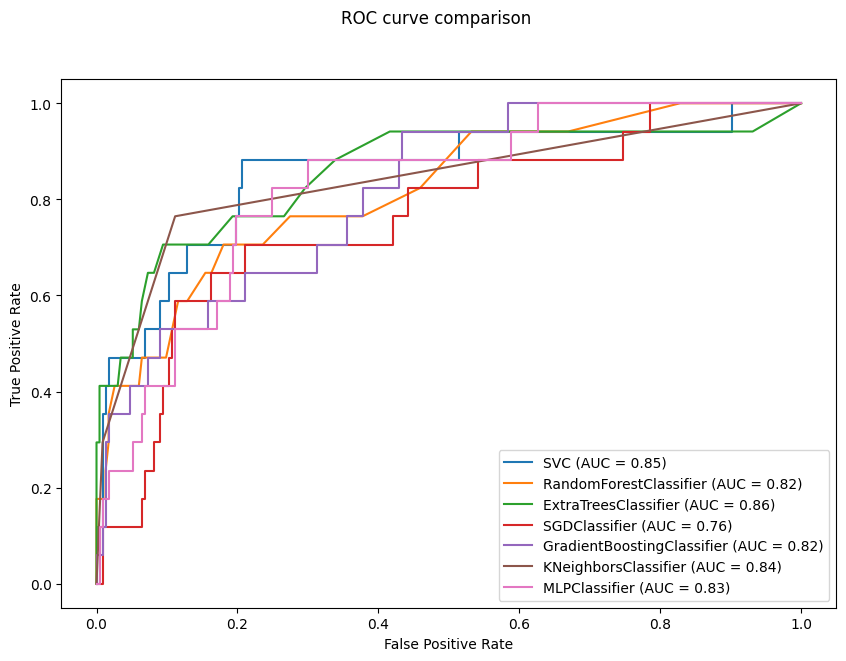

In [ ]:
svc = SVC(random_state=42)
svc.fit(dat['train_x_scaled'], dat['train_y']) 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(dat['train_x_scaled'], dat['train_y'])

extra = ExtraTreesClassifier()
extra.fit(dat['train_x_scaled'], dat['train_y']) 

log = SGDClassifier( )  #penalty = None and loss = log
log.fit(dat['train_x_scaled'], dat['train_y']) 

xgb = GradientBoostingClassifier()
xgb.fit(dat['train_x_scaled'], dat['train_y']) 

knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(dat['train_x_scaled'], dat['train_y']) 


plt.figure(figsize=(20,20))
svc_disp = plot_roc_curve(svc,     dat['test_x_scaled'], dat['test_y'])
rfc_disp = plot_roc_curve(rfc,     dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
extra_disp = plot_roc_curve(extra, dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
log_disp = plot_roc_curve(log, dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
xgb_disp = plot_roc_curve(xgb, dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
knn_disp = plot_roc_curve(knn, dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
MLP_disp = plot_roc_curve(MLPclassifier, dat['test_x_scaled'], dat['test_y'], ax=svc_disp.ax_)
MLP_disp.figure_.suptitle("ROC curve comparison")
plt.savefig("roc_curve_comparison.jpg")

In [ ]:
pred = MLPclassifier.predict(dat['test_x_scaled']) 
true = dat['test_y']
cf_matrix = confusion_matrix(true, pred)
cf_matrix

array([[222,  11],
       [ 13,   4]])

In [ ]:
pred2 = MLPclassifier.predict(dat['train_x_scaled']) 
true2 = dat['train_y']
cf_matrix2 = confusion_matrix(true2, pred2)
cf_matrix2

array([[921,   0],
       [  3,  75]])

In [ ]:
np.append(true, true2).shape

#### visualize results

In [ ]:
def print_confmat(cf_matrix):
  group_names = ['Correct non-crises','False alarms','Missed crises','Correct crises']
  group_counts = ["{0:0.0f}".format(value) for value in   cf_matrix.flatten()]
  group_percentages = ["{0:.0%}".format(value) for value in np.append( cf_matrix[0]/sum(cf_matrix[0]), cf_matrix[1]/sum(cf_matrix[1]) )]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  cmap = sns.diverging_palette(20, 220, as_cmap=True)
  cf_matrix_fake = [[4,3], [1.5,1.1]]
  sns.heatmap(np.log(cf_matrix_fake), annot=labels, fmt='', cmap = cmap, alpha = 0.5, 
              cbar=False, annot_kws={"size": 30},  xticklabels=False, yticklabels=False)


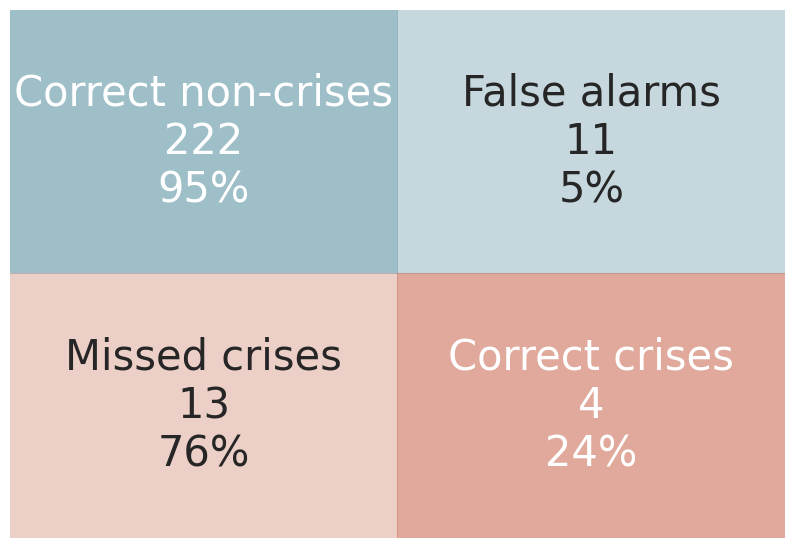

In [ ]:
print_confmat(cf_matrix)

In [ ]:
np.append(X_test, X_train, axis = 0).shape

(1249, 11)

In [ ]:
'''res = pd.DataFrame({'true': np.append(true, true2), 'pred': np.append(pred, pred2),
 'year' : np.append( data.iloc[idx_test]['year'] ,   data.iloc[idx_train]['year'] , axis=0),
 'iso': np.append( data.iloc[idx_test]['iso'] ,   data.iloc[idx_train]['iso'] , axis=0) })
'''
res = pd.DataFrame({'true': true, 'pred': pred, 'year': data.iloc[idx_test]['year'], 'iso': data.iloc[idx_test]['iso'] })

conditions  = [ (res.true==0) &(res.pred==0), (res.true==1) &(res.pred==0),(res.true==0) &(res.pred==1),(res.true==1) &(res.pred==1) ]
choices     = ['Correct non-crises',      'Missed crises',            'False alarms',            'Correct crises']
choices2     = [0,     1,            0,           1]
res["pred_class"] = np.select(conditions, choices, default=np.nan)
res["pred_num"] = np.select(conditions, choices2, default=np.nan)

#res.groupby('pred_class').count()
res.tail()

,true,pred,year,iso,pred_class,pred_num
573,0,0,1956,FRA,Correct non-crises,0.0
1055,0,0,2002,PRT,Correct non-crises,0.0
935,1,1,2006,NLD,Correct crises,1.0
1193,0,0,1951,USA,Correct non-crises,0.0
352,0,1,1900,DNK,False alarms,0.0


In [ ]:
print(data.pivot_table('year', index=  'iso',  aggfunc='count',margins=True ).fillna(0).T)
res.pivot_table('year', index=  'iso', columns='pred_class', aggfunc='count',margins=True ).fillna(0).style.format('{0:,.0f}')

iso   AUS  BEL  CAN  CHE  DEU  DNK  ESP  ...  JPN  NLD  NOR  PRT  SWE  USA   All
year  111   28   67   57   83   65   70  ...   76   77   67   57   95   89  1249

[1 rows x 18 columns]


pred_class,Correct crises,Correct non-crises,False alarms,Missed crises,All
iso,,,,,
AUS,0,18,2,1,21
BEL,0,4,0,0,4
CAN,0,13,1,0,14
CHE,0,14,0,0,14
DEU,0,19,1,1,21
DNK,0,11,1,1,13
ESP,0,16,1,0,17
FIN,0,7,0,1,8
FRA,1,15,0,1,17


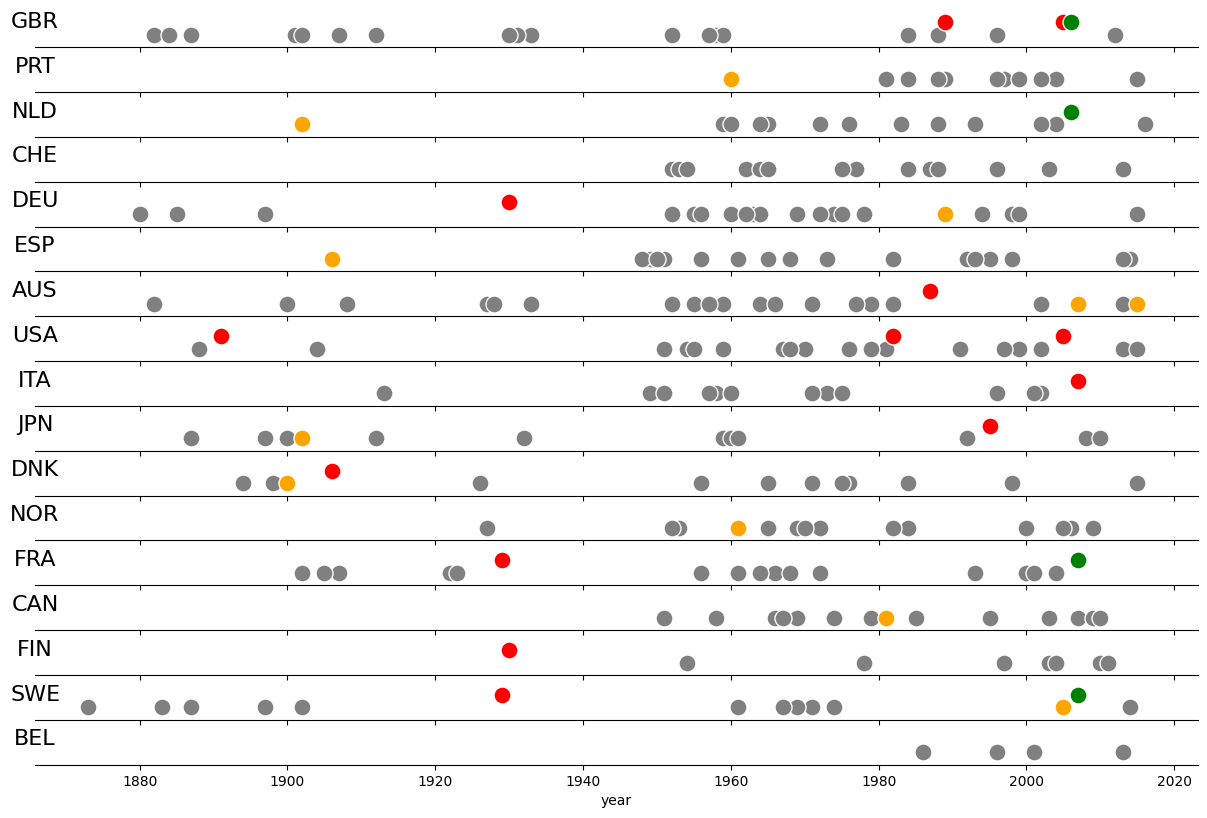

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

In [ ]:
n_iso = res.iso.unique().shape[0]
# MARKER SIZE
#plt.rcParams['lines.markersize'] ** 8.
f, axes = plt.subplots(n_iso, 1, figsize=(15, 10), sharex=True, sharey=False)
sns.despine(left = True)
counter = 0
yearf =0 # 1950
for c in res.iso.unique():
  axes[counter].set_title( c, x= 0, y=0.3, fontsize = 16) 
  plt.figure(figsize=(10,1))

  sns.scatterplot( data = res.loc[(res.pred_class=='Correct non-crises') & (res.iso == c) & (res.year >yearf)], x ='year', y ='pred_num', color = 'grey', ax=axes[counter],s=150)
  sns.scatterplot( data = res.loc[(res.pred_class=='False alarms') & (res.iso == c) & (res.year > yearf)], x ='year', y ='pred_num', color = 'orange',ax=axes[counter],s=150)
  sns.scatterplot( data = res.loc[(res.pred_class=='Missed crises') & (res.iso == c) & (res.year > yearf)], x ='year', y ='pred_num', color = 'red',ax=axes[counter],s=150)
  sns.scatterplot( data = res.loc[(res.pred_class=='Correct crises') & (res.iso == c) & (res.year > yearf)], x ='year', y ='pred_num', color = 'green',ax=axes[counter],s=150)
  #plt.ylim((-1,2))
  counter += 1

for ax in axes.flat:
    ax.set_ylim((-1,2))
    #ax.set_xlabel('year')
    ax.set_ylabel('')
    ax.set(yticks=[])


#plt.tight_layout()

## cross validation

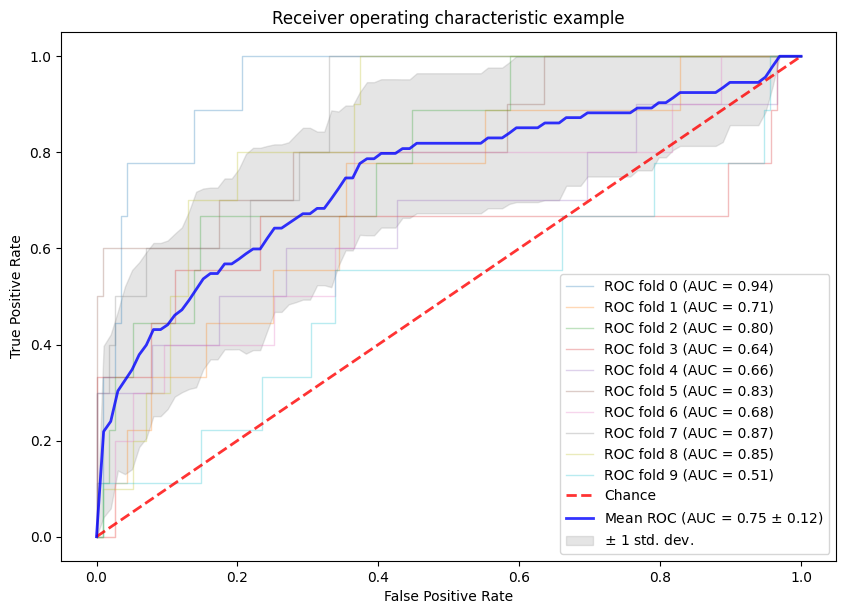

In [ ]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

classifier =  MLPClassifier(hidden_layer_sizes = bestparam["hidden_layer_sizes"], activation = bestparam["activation"], alpha=bestparam["alpha"], max_iter=5000 )

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    Xtrain = scaler.fit_transform(X[train])
    Xtest= scaler.transform(X[test])
    classifier.fit(Xtrain, Y[train])
    
    viz = plot_roc_curve(MLPclassifier, Xtest, Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic curve")
ax.legend(loc="lower right")
plt.show()

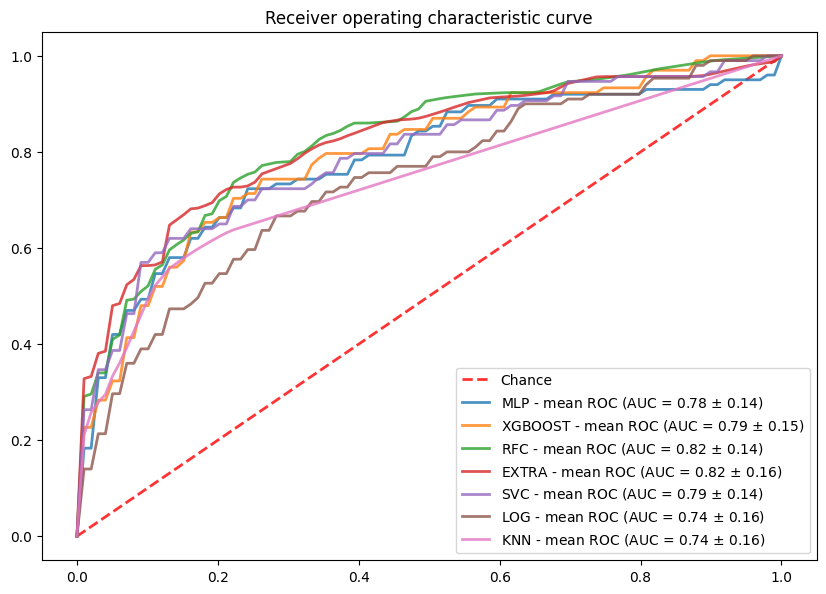

In [ ]:
# Run classifier with cross-validation and plot ROC curves
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn.model_selection import KFold


from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

cv = StratifiedKFold(n_splits=25)

SVC = SVC(random_state=42)
RFC = RandomForestClassifier(random_state=42)
EXTRA = ExtraTreesClassifier()
LOG = SGDClassifier( )  #penalty = None and loss = log
XGB = GradientBoostingClassifier()
KNN = KNeighborsClassifier(n_neighbors= 3)

MLPtprs = []  ;  MLPaucs = []  ; mean_fpr = np.linspace(0, 1, 100)
XGBtprs = []  ;  XGBaucs = []  
SVCtprs = []  ;  SVCaucs = []  
RFCtprs = []  ;  RFCaucs = []  
EXTRAtprs = []  ;  EXTRAaucs = []  
LOGtprs = []  ;  LOGaucs = []  
KNNtprs = []  ;  KNNaucs = []  


fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    # print(len(train))
    Xtrain = scaler.fit_transform(X[train])  ;     Xtest= scaler.transform(X[test])
    MLPclassifier.fit(Xtrain, Y[train]);      XGB.fit(Xtrain, Y[train]);
    SVC.fit(Xtrain, Y[train]);     RFC.fit(Xtrain, Y[train]) ; EXTRA.fit(Xtrain, Y[train]); 
    LOG.fit(Xtrain, Y[train]);      KNN.fit(Xtrain, Y[train]);

    viz = plot_roc_curve(MLPclassifier, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    MLPtprs.append(interp_tpr)  ;     MLPaucs.append(viz.roc_auc)

    viz = plot_roc_curve(XGB, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    XGBtprs.append(interp_tpr)  ;     XGBaucs.append(viz.roc_auc)

    viz = plot_roc_curve(SVC, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    SVCtprs.append(interp_tpr)  ;     SVCaucs.append(viz.roc_auc)
                                                     
    viz = plot_roc_curve(RFC, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    RFCtprs.append(interp_tpr)  ;     RFCaucs.append(viz.roc_auc)
    
    viz = plot_roc_curve(EXTRA, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    EXTRAtprs.append(interp_tpr)  ;     EXTRAaucs.append(viz.roc_auc)
    
    viz = plot_roc_curve(LOG, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    LOGtprs.append(interp_tpr)  ;     LOGaucs.append(viz.roc_auc)
    
    viz = plot_roc_curve(KNN, Xtest, Y[test])  ;     plt.close()
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)  ;   interp_tpr[0] = 0.0;
    KNNtprs.append(interp_tpr)  ;     KNNaucs.append(viz.roc_auc)


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# MLP
tprs = MLPtprs; aucs = MLPaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'MLP - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# XGBOOST
tprs = XGBtprs; aucs = XGBaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'XGBOOST - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# RFC
tprs = RFCtprs; aucs = RFCaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'RFC - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# EXTRA 
tprs = EXTRAtprs; aucs = EXTRAaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'EXTRA - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# SVC
tprs = SVCtprs; aucs = SVCaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'SVC - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# LOG
tprs = LOGtprs; aucs = LOGaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'LOG - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)
# KNN
tprs = KNNtprs; aucs = KNNaucs
mean_tpr = np.mean(tprs, axis=0)  ;  mean_tpr[-1] = 1.0  ; mean_auc = auc(mean_fpr, mean_tpr)  ; std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'KNN - mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),  lw=2, alpha=.8)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],   title="Receiver operating characteristic curve")
ax.legend(loc="lower right")
plt.show()

## predict probabilities for each country and year

In [ ]:
dfpred = df2.iloc[:,-3:]
dfpred['probcrisis'] = pd.DataFrame(classifier.predict_proba(df2.iloc[:, :-3]))[1]
dfpred

,crisis,year,iso,probcrisis
0,0,1872,AUS,0.117542
1,0,1873,AUS,0.061123
2,0,1874,AUS,0.049377
3,0,1875,AUS,0.035505
4,0,1876,AUS,0.090224
...,...,...,...,...
1244,0,2012,USA,0.009747
1245,0,2013,USA,0.003192
1246,0,2014,USA,0.004769
1247,0,2015,USA,0.011409


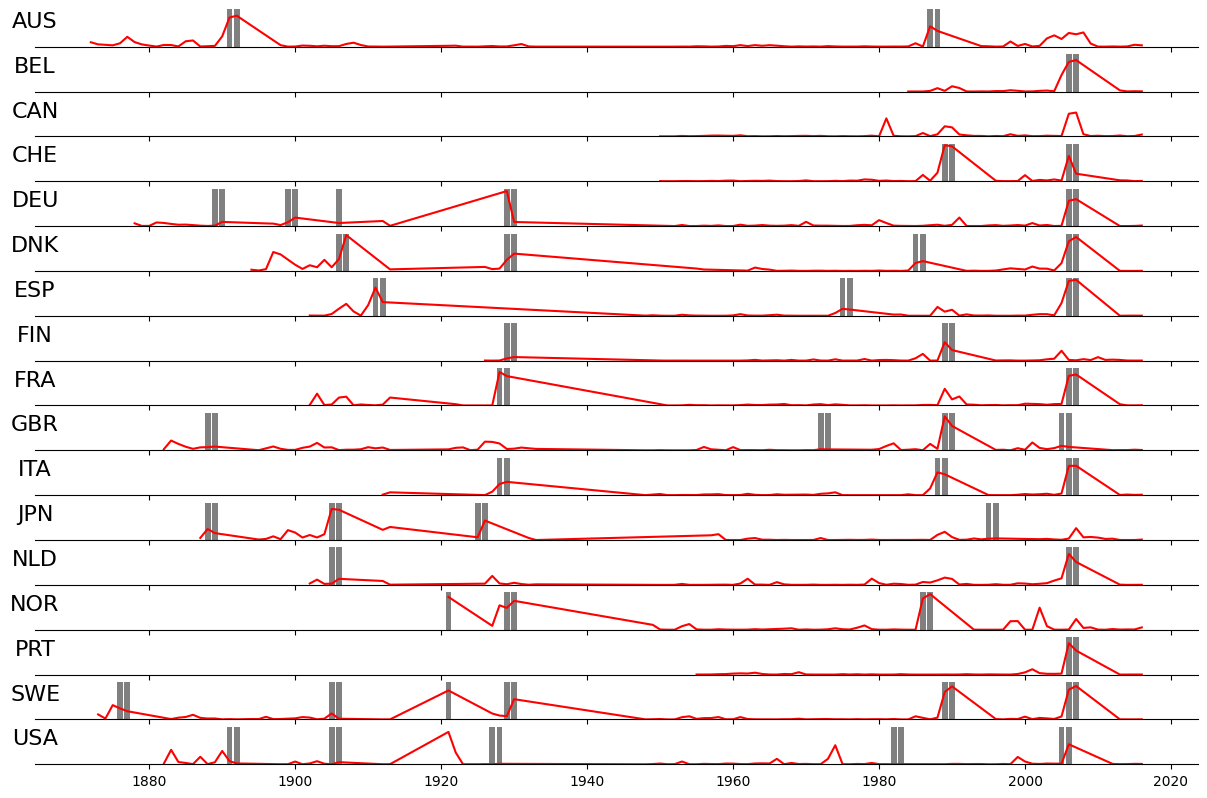

In [ ]:
fig, axes = plt.subplots(n_iso, 1, figsize=(15, 10), sharex=True, sharey=True)
sns.despine(left = True)
counter = 0
for c in sorted(res.iso.unique()):
  axes[counter].set_title( c, x= 0, y=0.3, fontsize = 16) 

  axes[counter].plot(dfpred[dfpred.iso == c]["year"],  dfpred[dfpred.iso == c]["probcrisis"], color = "r")
  axes[counter].bar(dfpred[dfpred.iso == c]["year"],  dfpred[dfpred.iso == c]["crisis"], color = "gray")
  counter += 1

for ax in axes.flat:
    ax.set_ylim((0,1))
    ax.set_ylabel('')
    ax.set(yticks=[])


# Most influential factors

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
features=feature_names

In [ ]:
features = ['CPI Consumer prices ', 'Broad money', 'Stock market', 'Consumption',
       'Public debt-to-GDP ratio', 'Investment-to-GDP ratio', 'Current account',
       'Domestic credit', 'Debt service ratio (interest on public debt)', 'Global credit (public debt)', 'Global slope (yield curve)']

In [ ]:
i = 2
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[i], feature_names=features)

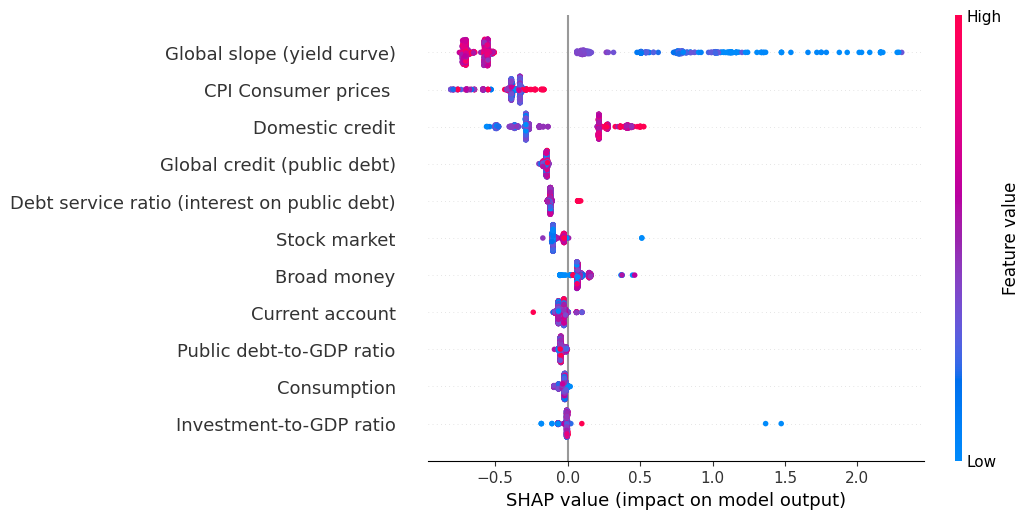

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train, feature_names=features)

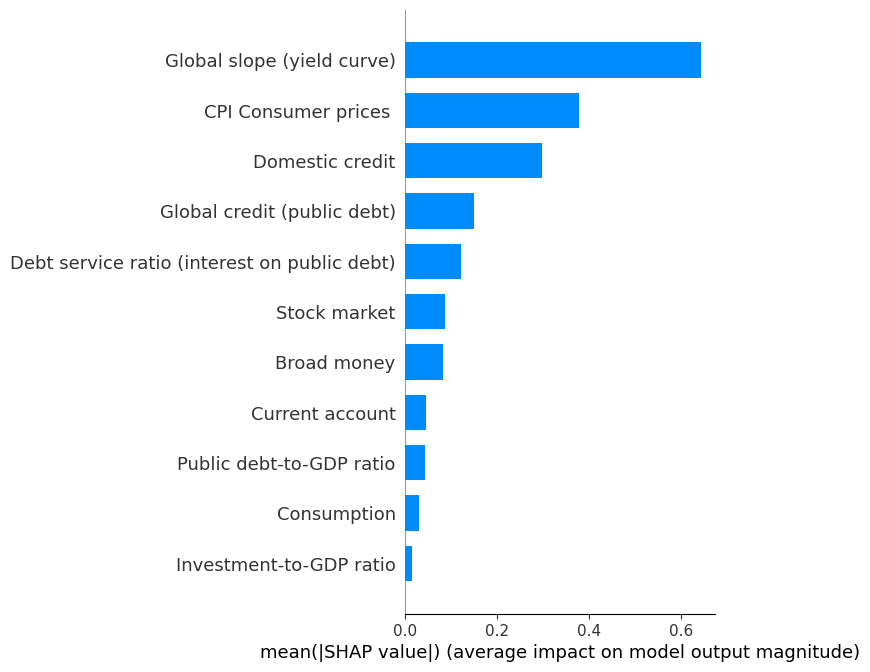

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features, plot_size=(4,8))

# LSTM

## preparation

In [ ]:
def reshape_data(obj):
    reshaped_obj = np.reshape(obj, (obj.shape[0], obj.shape[1], 1) )  # (obj.shape[0], obj.shape[1], 1)
    return reshaped_obj
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = X2_train_scaled.reshape( (X2_train_scaled.shape[0], 1, X2_train_scaled.shape[1]) )
test_X = X2_test_scaled.reshape((X2_test_scaled.shape[0], 1, X2_test_scaled.shape[1]))
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

(756, 1, 11) (999,) (190, 1, 11) (250,)


In [ ]:
# Reshape training data
reshaped_X1_train_scaled = reshape_data(dat['train_x_scaled'])
reshaped_X1_train = reshape_data(dat['train_x'])
# Reshape testing data
reshaped_X1_test_scaled = reshape_data(dat['test_x_scaled'])
reshaped_X1_test = reshape_data(dat['test_x'])

# No Preprocessing
# Reshape training data
reshaped_X1_train_scaled_nopr = reshape_data(dat_nopr['train_x_scaled'])
reshaped_X1_train_nopr = reshape_data(dat_nopr['train_x'])
# Reshape testing data
reshaped_X1_test_scaled_nopr = reshape_data(dat_nopr['test_x_scaled'])
reshaped_X1_test_nopr = reshape_data(dat_nopr['test_x'])



#### second dataset
# Reshape training data
reshaped_X2_train_scaled = reshape_data(X2_train_scaled )
reshaped_X2_train = reshape_data(X2_train)
# Reshape testing data
reshaped_X2_test_scaled = reshape_data(X2_test_scaled )
reshaped_X2_test = reshape_data(X2_test)

# No Preprocessing
# Reshape training data
reshaped_X2_train_scaled_nopr = reshape_data(X2_train_nopr_scaled  )
reshaped_X2_train_nopr = reshape_data(X2_train_nopr)
# Reshape testing data
reshaped_X2_test_scaled_nopr = reshape_data(X2_test_nopr_scaled )
reshaped_X2_test_nopr = reshape_data(X2_test_nopr)


In [ ]:
print(reshaped_X1_train_scaled.shape)
print(reshaped_X1_train_scaled_nopr.shape)

(999, 11, 1)
(1056, 11, 1)


In [ ]:
pos= y_test.sum()
neg= y_test.shape[0] - pos
initial_bias = np.log([pos/neg])
#initial_bias = -1
print(initial_bias)
#initial_bias = -5
initial_bias = tf.keras.initializers.Constant(initial_bias)

[-2.61782511]


## hyperparameter tunining

for both fully preprocessed and not fully preprocessed dataset

In [ ]:
t = TicToc()
t2 = TicToc()
def print_auc_LSTM(dropoutrate1,dropoutrate2, add_layer,activation, learning_rate, epochs ):
    t.tic()
    comb.append( [dropoutrate1,dropoutrate2, add_layer, activation, learning_rate] )
    print( dropoutrate1,dropoutrate2, add_layer, activation, learning_rate )

    model = Sequential()
  
    model.add(LSTM(128,  input_shape=(reshaped_X1_train.shape[1],1),  return_sequences=True))
    model.add(Dropout(dropoutrate1))

    if add_layer:
      model.add(LSTM(32, return_sequences=True))
      model.add(Dropout(dropoutrate2))
      model.add(LSTM(32, return_sequences=False))
      model.add(Dropout(dropoutrate2))
    else:
      model.add(LSTM(32, return_sequences=False))
      model.add(Dropout(dropoutrate2))
  
    model.add(Dense(1, activation=activation, bias_initializer=initial_bias))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    model.fit(reshaped_X1_train, dat['train_y'], validation_split=0.3, epochs=epochs, shuffle=True, verbose=0)
    
    model_loss1, auc = model.evaluate(reshaped_X1_test, dat['test_y'], verbose=1) 
    print(auc)
    aucs.append(auc)
    tempo.append(t.tocvalue() )


    t2.tic()

    model2 = Sequential()
  
    model2.add(LSTM(128,  input_shape=(reshaped_X1_train_nopr.shape[1],1),  return_sequences=True))
    model2.add(Dropout(dropoutrate1))

    if add_layer:
      model2.add(LSTM(32, return_sequences=True))
      model2.add(Dropout(dropoutrate2))
      model2.add(LSTM(32, return_sequences=False))
      model2.add(Dropout(dropoutrate2))
    else:
      model2.add(LSTM(32, return_sequences=False))
      model2.add(Dropout(dropoutrate2))
  
    model2.add(Dense(1, activation=activation, bias_initializer=initial_bias))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    model2.fit(reshaped_X1_train_nopr, dat_nopr['train_y'], validation_split=0.3, epochs=epochs, shuffle=True, verbose=0)
    
    model_loss2, auc2 = model2.evaluate(reshaped_X1_test_nopr, dat_nopr['test_y'], verbose=1) 
    print(auc2)
    aucs2.append(auc2)
    tempo2.append(t2.tocvalue() )

In [ ]:
aucs = []
tempo  = []
aucs2 = []
comb = []
tempo2  = []
for dropoutrate1 in [0.4, 0.5, 0.6]:
  for dropoutrate2 in [0.4, 0.5, 0.6]:
    for add_layer in [True, False]:
      for activation in ['sigmoid']:
        for learning_rate in [0.01, 0.005, 0.015 ]:
          print_auc_LSTM(dropoutrate1,dropoutrate2, add_layer, activation, learning_rate, epochs = 100)

0.4 0.4 True sigmoid 0.01
8/8 [==============================] - 0s 7ms/step - loss: 0.2621 - auc: 0.6584
0.6584195494651794
9/9 [==============================] - 0s 7ms/step - loss: 0.2037 - auc: 0.7492
0.7491999864578247
0.4 0.4 True sigmoid 0.005
8/8 [==============================] - 0s 7ms/step - loss: 0.2597 - auc: 0.6868
0.6868215203285217
9/9 [==============================] - 0s 7ms/step - loss: 0.1982 - auc: 0.7928
0.7928000092506409
0.4 0.4 True sigmoid 0.015
8/8 [==============================] - 0s 7ms/step - loss: 0.2409 - auc: 0.6862
0.6861903667449951
9/9 [==============================] - 0s 7ms/step - loss: 0.2210 - auc: 0.5000
0.5
0.4 0.4 False sigmoid 0.01
8/8 [==============================] - 0s 6ms/step - loss: 0.2620 - auc: 0.6534
0.6533703804016113
9/9 [==============================] - 0s 6ms/step - loss: 0.2123 - auc: 0.7944
0.7943999767303467
0.4 0.4 False sigmoid 0.005
8/8 [==============================] - 0s 6ms/step - loss: 0.3069 - auc: 0.7073
0.707270

In [ ]:
res = pd.DataFrame( comb , columns=["dropoutrate1","dropoutrate2", "add_layer","activation", "learning_rate"])
res['auc'] = aucs
res['time'] = tempo
res.sort_values(by=["auc"], ascending= False).head(3)


,dropoutrate1,dropoutrate2,add_layer,activation,learning_rate,auc,time
6,0.4,0.5,True,sigmoid,0.010,0.753471,67.614754
17,0.4,0.6,False,sigmoid,0.015,0.742237,54.896128
37,0.6,0.4,True,sigmoid,0.005,0.736935,66.629121


In [ ]:
res2 = pd.DataFrame( comb , columns=["dropoutrate1","dropoutrate2", "add_layer","activation", "learning_rate"])
res2['auc'] = aucs2
res2['time'] = tempo2
res2.sort_values(by=["auc"], ascending= False).head(3)

,dropoutrate1,dropoutrate2,add_layer,activation,learning_rate,auc,time
19,0.5,0.4,True,sigmoid,0.005,0.820133,71.010394
10,0.4,0.5,False,sigmoid,0.005,0.817467,57.885341
4,0.4,0.4,False,sigmoid,0.005,0.815600,57.361007


In [ ]:
print('Total time for the elaboration', round ( res.time.sum()/60 + res2.time.sum()/60), 'mins')
res.sort_values(by=["auc"], ascending= False).to_csv("res.csv")
res2.sort_values(by=["auc"], ascending= False).to_csv("res2.csv")

Total time for the elaboration 113 mins


In [ ]:
model.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_270 (LSTM)              (None, 11, 128)           66560     
_________________________________________________________________
dropout_270 (Dropout)        (None, 11, 128)           0         
_________________________________________________________________
lstm_271 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_271 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


Following a check over the effect of regularization of the kernel (L2: Sum of the squared weights.)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    loss, auc = model.evaluate(reshaped_X1_train, y_train, verbose=0)
    aucs_train.append(auc)
    loss, auc = model.evaluate(reshaped_X1_test, y_test, verbose=0)
    aucs.append(auc)
    print('.', end='')
    if epoch % 25 == 0: 
      print('' , epoch, ' auc: ', round(auc,2))

dropoutrate1  = 0.5 ;dropoutrate2  = 0.4;  activation = 'sigmoid'
learning_rate  =0.005;   opt = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)   # 'val_loss'

cv = 10
epochs = 100

aucs = []; aucs_train = []

#regularized model
for i in range(cv):
  print("\nreg" + str(i) )
  model = None
  model = Sequential()
  model.add(LSTM(128,input_shape=(reshaped_X1_train.shape[1],1),  return_sequences=True,
                kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dropout(dropoutrate1))
  model.add(LSTM(32, return_sequences=False))
  model.add(Dropout(dropoutrate2))
  model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
  model.fit(reshaped_X1_train, y_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop, PrintDot()])

# not regularized model
for i in range(cv):
  print("\nunreg" + str(i) )
  model = None
  model = Sequential()
  model.add(LSTM(128,input_shape=(reshaped_X1_train.shape[1],1),  return_sequences=True))
  model.add(Dropout(dropoutrate1))
  model.add(LSTM(32, return_sequences=False))
  model.add(Dropout(dropoutrate2))
  model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
  model.fit(reshaped_X1_train, y_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop, PrintDot()])



reg0
.......................... 25  auc:  0.67
..........................................................................
reg1
.......................... 25  auc:  0.67
..........................................................................
reg2
.......................... 25  auc:  0.67
..........................................................................
reg3
.......................... 25  auc:  0.68
..........................................................................
reg4
.......................... 25  auc:  0.67
..........................................................................
reg5
.......................... 25  auc:  0.67
..........................................................................
reg6
.......................... 25  auc:  0.67
..........................................................................
reg7
.......................... 25  auc:  0.67
..........................................................................
reg8
..................

In [ ]:
case = [r +"-"+str(i) +"-" + str(ep+1) for r in ("regular", "unreg") for i in range(cv) for ep in range(epochs)] 

res = pd.DataFrame({ "case": case, "aucs train": aucs_train,"aucs test": aucs,}  )
res = pd.concat( [res, res.case.str.split("-", n = 2,expand=True).rename({0: 'reg', 1: 'cv', 2:'epoch'}, axis=1)], axis  = 1)
res.head()

,case,aucs train,aucs test,reg,cv,epoch
0,regular-0-1,0.704453,0.637213,regular,0,1
1,regular-0-2,0.703047,0.652739,regular,0,2
2,regular-0-3,0.710286,0.653497,regular,0,3
3,regular-0-4,0.711302,0.645292,regular,0,4
4,regular-0-5,0.713125,0.654128,regular,0,5


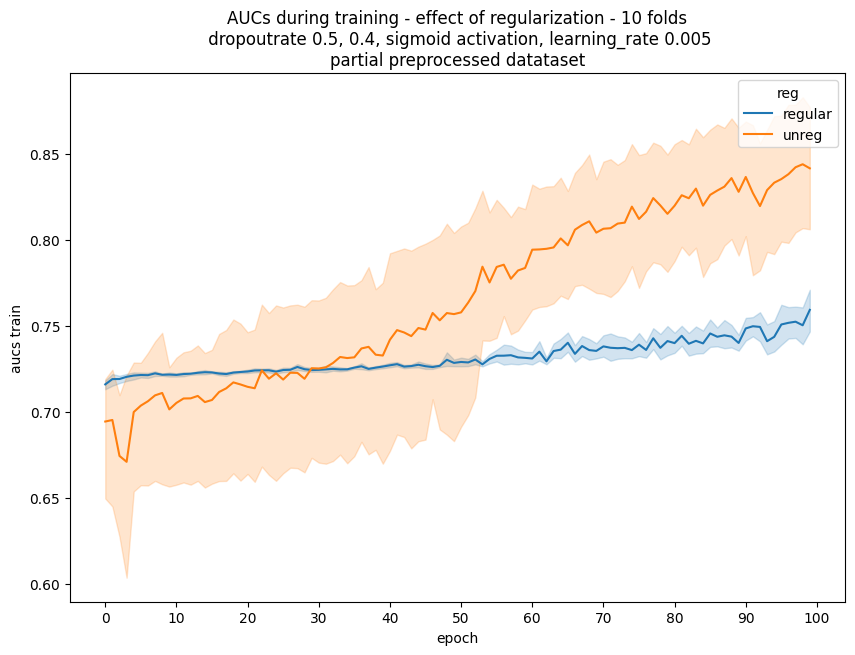

In [ ]:
import matplotlib.ticker as ticker
p= sns.lineplot(data =res, x = 'epoch', y= 'aucs train', hue = 'reg' )
p.xaxis.set_major_locator(ticker.MultipleLocator(10))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title('AUCs during training - effect of regularization - 10 folds\n dropoutrate 0.5, 0.4, sigmoid activation, learning_rate 0.005\nfully preprocessed datataset')
plt.show()

Text(0.5, 1.0, 'AUCs during test - effect of regularization - 10 folds\n dropoutrate 0.5, 0.4, sigmoid activation, learning_rate 0.005\npartial preprocessed datataset')

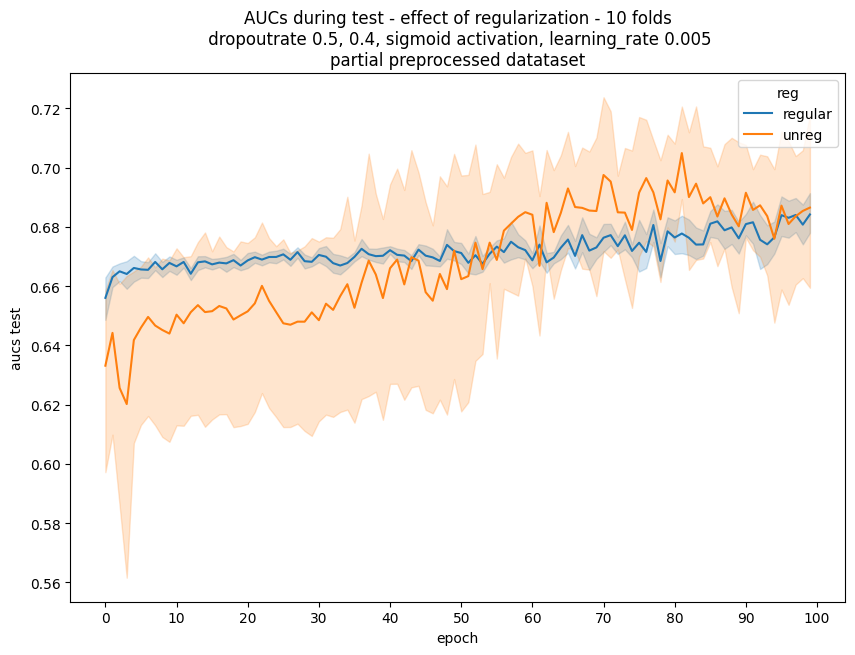

In [ ]:
p = sns.lineplot(data =res, x = 'epoch', y= 'aucs test', hue = 'reg' )
p.xaxis.set_major_locator(ticker.MultipleLocator(10))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title('AUCs during test - effect of regularization - 10 folds\n dropoutrate 0.5, 0.4, sigmoid activation, learning_rate 0.005\nfully preprocessed datataset')

## “Dropout”, “Monte-Carlo Dropout” performance comparisons

In [ ]:
class MCDropout(tf.keras.layers.Layer):
    def __init__(self, rate):
        super(MCDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    loss, auc = model.evaluate(reshaped_X2_train, y2_train, verbose=0)
    aucs_train.append(auc)
    loss, auc = model.evaluate(reshaped_X2_test, y2_test, verbose=0)
    aucs.append(auc)
    print('.', end='')
    if epoch % 50 == 0: 
      print('' , epoch, ' auc: ', round(auc,2))

cv = 10  ;  epochs = 100
dropoutrate1  = 0.5 ;dropoutrate2  = 0.4;  activation = 'sigmoid'; learning_rate  =0.005
opt = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)   # 'val_loss'

aucs = []; aucs_train = []

# standard dropout
model = None
model = Sequential()
model.add(LSTM(128,input_shape=(reshaped_X2_train.shape[1],1),  return_sequences=True))
model.add(Dropout(dropoutrate1))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(dropoutrate2))
model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

for i in range(cv):
  model.fit(reshaped_X2_train, y2_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop, PrintDot()])

# montecarlo dropout
model = None
model = Sequential()
model.add(LSTM(128,input_shape=(reshaped_X2_train.shape[1],1),  return_sequences=True))
model.add(MCDropout(dropoutrate1))
model.add(LSTM(32, return_sequences=False))
model.add(MCDropout(dropoutrate2))
model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

for i in range(cv):
  model.fit(reshaped_X2_train, y2_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop, PrintDot()])

. 0  auc:  0.72
.................................................. 50  auc:  0.86
.................................................. 0  auc:  0.85
.................................................. 50  auc:  0.91
.................................................. 0  auc:  0.95
.................................................. 50  auc:  0.93
.................................................. 0  auc:  0.88
.................................................. 50  auc:  0.92
.................................................. 0  auc:  0.92
.................................................. 50  auc:  0.88
.................................................. 0  auc:  0.87
.................................................. 50  auc:  0.83
.................................................. 0  auc:  0.93
.................................................. 50  auc:  0.87
.................................................. 0  auc:  0.86
.................................................. 50  auc:  0.91
.

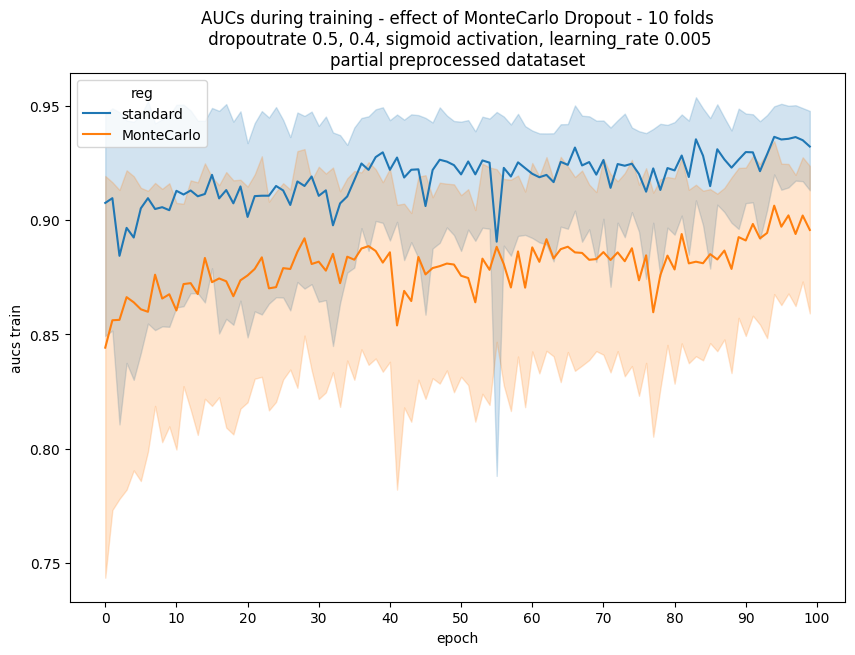

In [ ]:
case = [r +"-"+str(i) +"-" + str(ep+1) for r in ("standard", "MonteCarlo") for i in range(cv) for ep in range(epochs)] 

res = pd.DataFrame({ "case": case, "aucs train": aucs_train,"aucs test": aucs,}  )
res = pd.concat( [res, res.case.str.split("-", n = 2,expand=True).rename({0: 'reg', 1: 'cv', 2:'epoch'}, axis=1)], axis  = 1)
res.head()

p= sns.lineplot(data =res, x = 'epoch', y= 'aucs train', hue = 'reg' )
p.xaxis.set_major_locator(ticker.MultipleLocator(10))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title('AUCs during training - effect of MonteCarlo Dropout - 10 folds\n dropoutrate 0.5, 0.4, sigmoid activation, learning_rate 0.005\npartial preprocessed datataset')
plt.show()

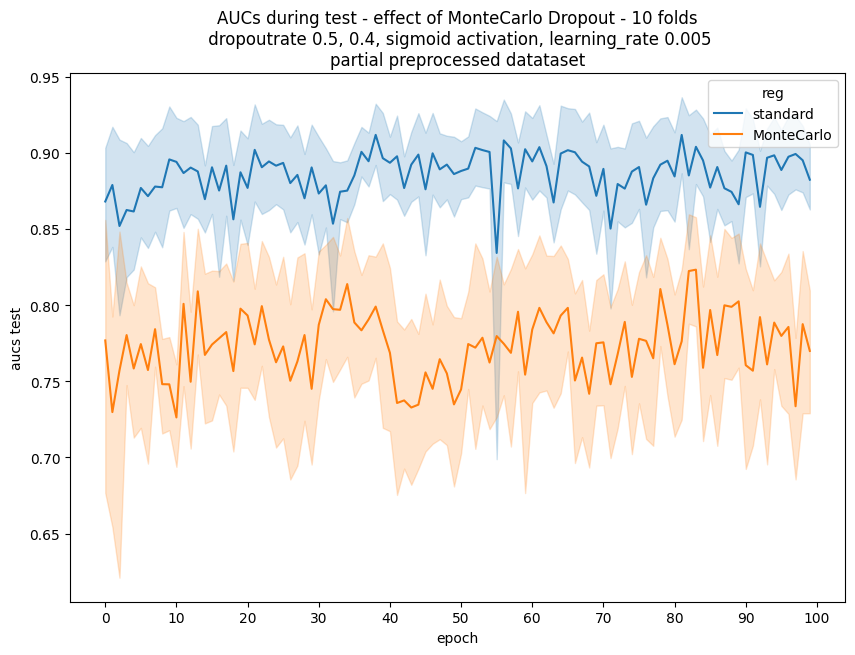

In [ ]:
p= sns.lineplot(data =res, x = 'epoch', y= 'aucs test', hue = 'reg' )
p.xaxis.set_major_locator(ticker.MultipleLocator(10))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title('AUCs during test - effect of MonteCarlo Dropout - 10 folds\n dropoutrate 0.5, 0.4, sigmoid activation, learning_rate 0.005\npartial preprocessed datataset')
plt.show()

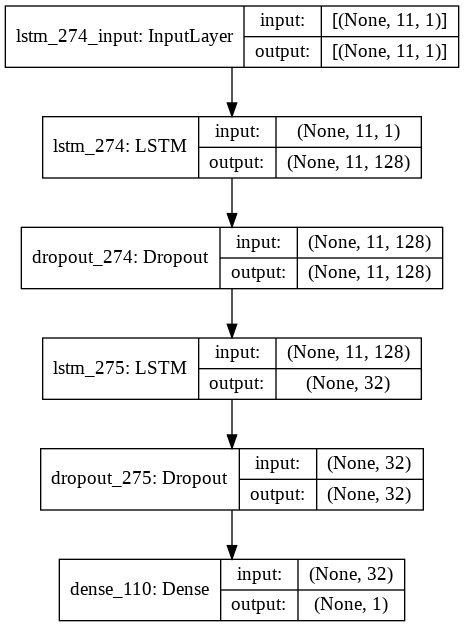

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_274 (LSTM)              (None, 11, 128)           66560     
_________________________________________________________________
dropout_274 (Dropout)        (None, 11, 128)           0         
_________________________________________________________________
lstm_275 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_275 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = np.array( model.predict(reshaped_X2_test))
y_pred_train  = np.array( model.predict(reshaped_X2_train))

for i in range(15):
  thr = 0.0+ i/20
  con_mat = confusion_matrix(y2_train, y_pred_train  > thr)
  con_mat_test = confusion_matrix(y2_test, y_pred> thr)
  print("\nthr: " ,thr ,"\t" , round( roc_auc_score(y2_train, y2_pred_train  > thr), 2) , "\t\t\t" , round(roc_auc_score(y2_test, y2_pred> thr), 2))
  print("\t", con_mat.flatten() ,"\t", con_mat_test.flatten() )
print_confmat(confusion_matrix(y2_test, y2_pred> 0.1))

## effect of year filtering (> 1950) processed dataset

In [ ]:
cv = 10 ;  epochs = 100
dropoutrate1  = 0.5 ;dropoutrate2  = 0.4;  activation = 'sigmoid'; learning_rate  =0.005
opt = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)   # 'val_loss'

aucs = []; aucs_train = []; confmat = []
thr = 0.1
#  preprocessed dataset
model = None
model = Sequential()
model.add(LSTM(128,input_shape=(reshaped_X1_train.shape[1],1),  return_sequences=True))
model.add(Dropout(dropoutrate1))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(dropoutrate2))
model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

for i in range(cv):
  print(i)
  model.fit(reshaped_X1_train, y_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop])
  y_pred = np.array( model.predict(reshaped_X1_test))
  confmat.append( confusion_matrix(y_test, y_pred  > thr).flatten() )

#  preprocessed dataset year > 1950
model = None
model = Sequential()
model.add(LSTM(128,input_shape=(reshaped_X2_train.shape[1],1),  return_sequences=True))
model.add(Dropout(dropoutrate1))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(dropoutrate2))
model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

for i in range(cv):
  print(i)
  model.fit(reshaped_X2_train, y2_train, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop])
  y_pred = np.array( model.predict(reshaped_X2_test))
  confmat.append( confusion_matrix(y2_test, y_pred  > thr).flatten() )

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [ ]:
case = [r +"-"+str(i)  for r in ("full", "year ") for i in range(cv) ] 
res = pd.DataFrame(confmat, columns= ['TP', 'FP', 'FN', 'TN']) 
case = pd.DataFrame(case)
res = pd.concat( [res, case[0].str.split("-", n = 2,expand=True).rename({0: 'type', 1: 'cv'}, axis=1)], axis  = 1)
res = res.groupby('type').mean()

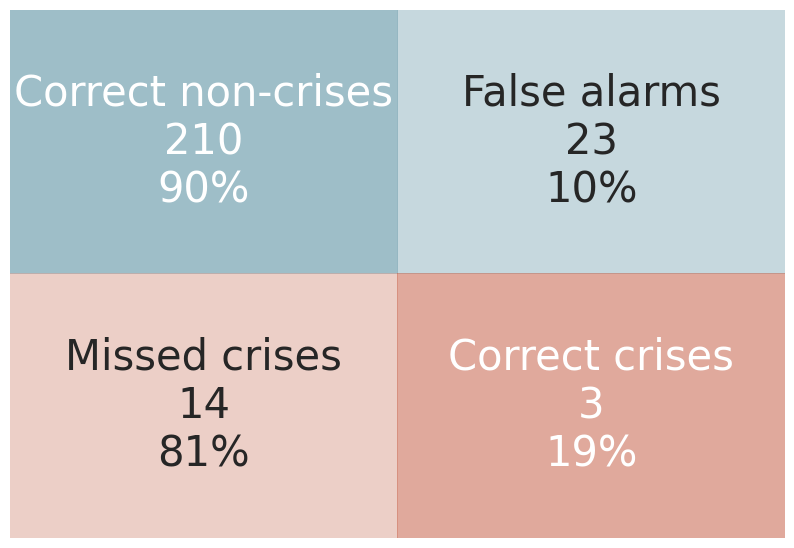

In [ ]:
#fully preprocessed dataset
print_confmat(res.iloc[0].values.reshape(2,2) )

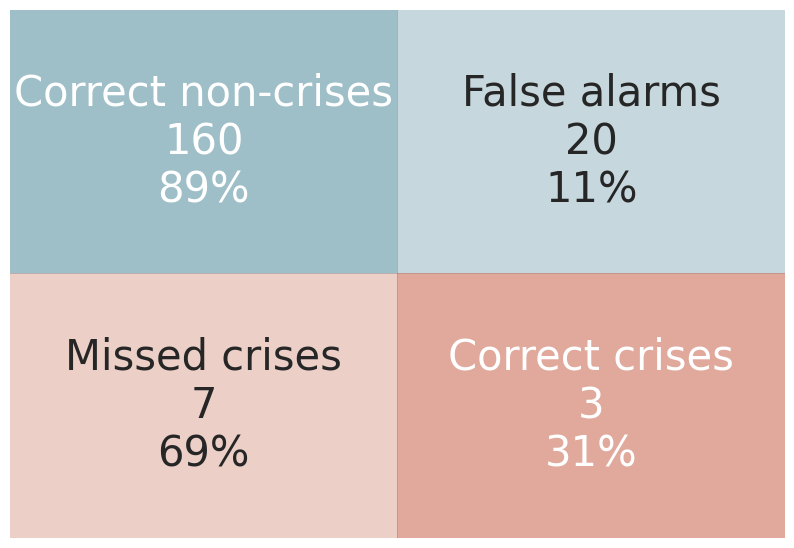

In [ ]:
#year > 1950 preprocessed dataset
print_confmat(res.iloc[1].values.reshape(2,2) )

## effect of preprocessing 

In [ ]:
cv = 10 ;  epochs = 100
dropoutrate1  = 0.5 ;dropoutrate2  = 0.4;  activation = 'sigmoid'; learning_rate  =0.005
opt = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)   # 'val_loss'

aucs = []; aucs_train = []; confmat = []
thr = 0.1
#  partial preprocessed dataset
model = None
model = Sequential()
model.add(LSTM(128,input_shape=(reshaped_X1_train_nopr  .shape[1],1),  return_sequences=True))
model.add(Dropout(dropoutrate1))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(dropoutrate2))
model.add(Dense(1, activation=activation, bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

for i in range(cv):
  print(i)
  model.fit(reshaped_X1_train_nopr, y_train_nopr, validation_split=0.3, epochs=epochs,  shuffle=True, verbose=0, callbacks=[early_stop])
  y_pred = np.array( model.predict(reshaped_X1_test_nopr))
  confmat.append( confusion_matrix(y_test_nopr, y_pred  > thr).flatten() )

0
1
2
3
4
5
6
7
8
9


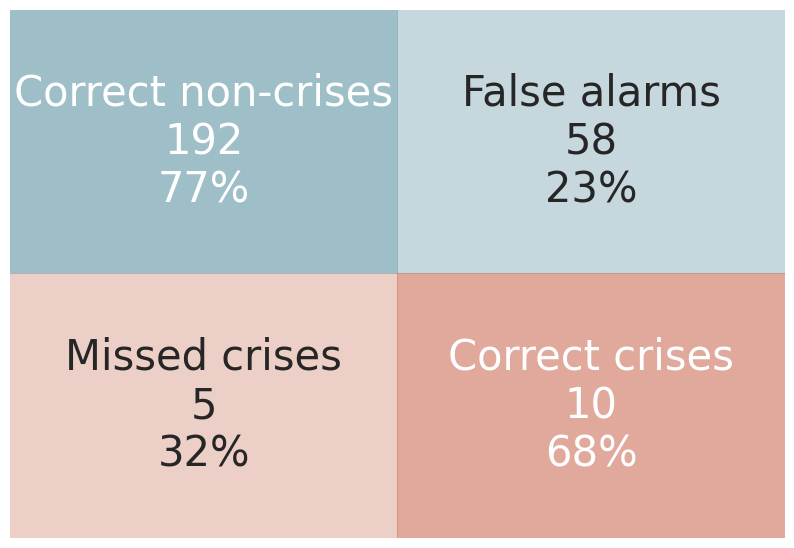

In [ ]:
res = pd.DataFrame(confmat, columns= ['TP', 'FP', 'FN', 'TN']) 
res = res.mean()
print_confmat(res.values.reshape(2,2) )

## One Hot Encoding


In [ ]:
df3 = df2[df2.year > 0].copy()

In [ ]:
iso = 'ITA'
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [ ]:
slicedf = pd.concat([ pd.get_dummies(df3.iso), df3.drop("iso", axis = 1)], axis = 1).set_index('year')

X_train, X_test, y_train, y_test = train_test_split(slicedf.iloc[:, :-1], slicedf.iloc[:,-1], test_size=0.2, random_state=42)
X_train_r = reshape_data(np.array(X_train)); X_test_r = reshape_data(np.array(X_test));

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    loss, auc = model.evaluate(X_train_r, y_train, verbose=0)
    aucs_train.append(auc)
    loss, auc = model.evaluate(X_test_r, y_test, verbose=0)
    aucs.append(auc)
    print('.', end='')
    if epoch % 25 == 0: 
      print('\n ' , epoch, ' auc: ', auc)
  

dropoutrate1  = 0.4
dropoutrate2  = 0.6
activation = 'sigmoid'
learning_rate  =0.010
epochs = 100
aucs = []
aucs_train = []

model = None
model = Sequential()

model.add(LSTM(128,  input_shape=(X_train_r.shape[1],1),  return_sequences=True))
model.add(Dropout(dropoutrate1))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(dropoutrate2))

model.add(Dense(1, activation=activation, bias_initializer=initial_bias))

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)   # 'val_loss'

model.fit(X_train_r, y_train, validation_split=0.3, epochs=epochs,  shuffle=False, verbose=0, callbacks=[early_stop, PrintDot()] ) # class_weight = {0:100,1:1}

# Evaluate model using test data
model_loss1, auc = model.evaluate(X_test_r, y_test, verbose=0)
print('auc', auc)

In [ ]:
pd.DataFrame(aucs).rolling(window = 5, center= True).mean().plot()

In [ ]:
y_pred = np.array( model.predict(X_test_r))
y_pred_train  = np.array( model.predict(X_train_r))

for i in range(15):
  thr = 0.0+ i/40
  con_mat = confusion_matrix(y_train, y_pred_train  > thr)
  con_mat_test = confusion_matrix(y_test, y_pred> thr)
  print("\nthr: " ,thr ,"\t" , round( roc_auc_score(y_train, y_pred_train  > thr), 2) , "\t\t\t" , round(roc_auc_score(y_test, y_pred> thr), 2))
  print("\t", con_mat.flatten() ,"\t", con_mat_test.flatten() )


In [ ]:
print_confmat(confusion_matrix(y_test, y_pred> 0.025))